In [1]:
import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image


In [2]:
df0 = pd.read_fwf('../PCC_cat.txt', header=None)
df0

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [3]:
# join on specObj to see if missmatch b/t PhotoObj type and SpecObj type
# also want to see if objects in PCC appear


# Search with Spectroscopic join
radialSearchSpec = f'SELECT TOP 300 p.objID, p.ra, p.dec, \
 p.modelMag_r, \
 p.modelMag_u - p.modelMag_g as u_g, \
 p.modelMag_g - p.modelMag_z as g_z, \
 p.modelMag_g - p.modelMag_r as g_r, \
 p.modelMag_g - p.modelMag_i as g_i, \
 p.modelMag_r - p.modelMag_i as r_i, \
 p.modelMag_r - p.modelMag_z as r_z, \
 p.petroRad_r, p.flags, dbo.fPhotoFlagsN(p.flags) as flag_text, \
 s.specObjID, s.z, s.zErr, s.zWarning, s.class, s.subClass, \
 N.distance \
FROM\
 photoObj as p \
JOIN SpecObjAll s ON p.objID = s.bestObjID \
JOIN dbo.fGetNearbyObjEq(49.9467, 41.5131, 45) as N ON N.objID = p.objID \
WHERE \
 p.modelMag_r > -14.3*(p.modelMag_g - p.modelMag_z) + 37 \
 and p.modelMag_r < -14.3*(p.modelMag_g - p.modelMag_z) + 46 \
 and p.type = 3 \
ORDER BY distance'

# Search with no Spectroscopic join
radialSearchNoSpec = f'SELECT TOP 300 p.objID, p.ra, p.dec, \
 p.modelMag_r, \
 p.modelMag_u - p.modelMag_g as u_g, \
 p.modelMag_g - p.modelMag_z as g_z, \
 p.modelMag_g - p.modelMag_r as g_r, \
 p.modelMag_g - p.modelMag_i as g_i, \
 p.modelMag_r - p.modelMag_i as r_i, \
 p.modelMag_r - p.modelMag_z as r_z, \
 p.petroRad_r, p.flags, dbo.fPhotoFlagsN(p.flags) as flag_text, \
 N.distance \
FROM\
 photoObj as p \
JOIN dbo.fGetNearbyObjEq(49.9467, 41.5131, 45) as N ON N.objID = p.objID \
WHERE \
 p.modelMag_r > -14.3*(p.modelMag_g - p.modelMag_z) + 37 \
 and p.modelMag_r < -14.3*(p.modelMag_g - p.modelMag_z) + 46 \
 and p.type = 3 \
ORDER BY distance'

## No color cuts
radialSearchNoColor = f'SELECT TOP 300 p.objID, p.ra, p.dec, \
 p.modelMag_r, \
 p.modelMag_r - p.extinction_r as r0, \
 p.modelMag_g - p.extinction_g - p.modelMag_z + p.extinction_z as g_z0, \
 p.modelMag_u - p.modelMag_g as u_g, \
 p.modelMag_g - p.modelMag_z as g_z, \
 p.modelMag_g - p.modelMag_r as g_r, \
 p.modelMag_g - p.modelMag_i as g_i, \
 p.modelMag_r - p.modelMag_i as r_i, \
 p.modelMag_r - p.modelMag_z as r_z, \
 p.petroRad_r, p.flags, dbo.fPhotoFlagsN(p.flags) as flag_text, \
 s.specObjID, s.z, s.zErr, s.zWarning, s.class, s.subClass, \
 N.distance \
FROM \
    photoObj as p \
JOIN SpecObjAll s ON p.objID = s.bestObjID \
JOIN dbo.fGetNearbyObjEq(49.9467, 41.5131, 45) as N ON N.objID = p.objID \
WHERE \
    p.type = 3 \
ORDER BY distance'


searchDf = CasJobs.executeQuery(radialSearchNoColor, "dr16")
searchDf

,objID,ra,dec,modelMag_r,r0,g_z0,u_g,g_z,g_r,g_i,...,petroRad_r,flags,flag_text,specObjID,z,zErr,zWarning,class,subClass,distance
0,1237661059574334072,49.932572,41.456982,15.13689,14.76837,1.594644,2.148634,1.923657,1.009280,1.530828,...,6.452093,35184640524304,DEBLENDED_AT_EDGE BINNED1 CHILD,1875797123736299520,0.013025,0.000007,0,GALAXY,BROADLINE,3.426438
1,1237661059574334072,49.932572,41.456982,15.13689,14.76837,1.594644,2.148634,1.923657,1.009280,1.530828,...,6.452093,35184640524304,DEBLENDED_AT_EDGE BINNED1 CHILD,1874671223577798656,0.013032,0.000007,0,GALAXY,BROADLINE,3.426438
2,1237661059574334114,50.029920,41.552969,18.42844,18.05426,2.554867,3.159212,2.888931,1.524950,2.367767,...,1.115180,105624251793752,DEBLEND_NOPEAK DEBLENDED_AT_EDGE STATIONARY MO...,1875902951730472960,-0.000345,0.000011,0,STAR,M1,4.437714
3,1237661059574399247,49.988331,41.445875,18.05160,17.68357,2.488631,2.727100,2.817200,1.565123,2.373089,...,1.147057,35253360136208,DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP CO...,1875796848858392576,0.000052,0.000009,0,STAR,M0,4.446487
4,1237661059574399247,49.988331,41.445875,18.05160,17.68357,2.488631,2.727100,2.817200,1.565123,2.373089,...,1.147057,35253360136208,DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP CO...,1874672323089426432,0.000061,0.000009,0,STAR,M0,4.446487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,1237661055818990429,50.905891,41.366465,17.20432,16.78527,1.720221,1.971970,2.094337,1.089518,1.636820,...,3.681080,34628173824,BAD_MOVING_FIT BINNED1,1874631916037105664,0.048023,0.000013,0,GALAXY,,44.031249
292,1237661083199472188,50.184406,40.800759,16.81091,16.47613,0.636899,1.468370,0.935785,0.586376,0.823126,...,1.141926,68987912192,STATIONARY BINNED1,1875786128620021760,-0.000329,0.000009,0,STAR,F9,44.068734
293,1237661121850901163,48.999980,41.287510,16.52428,16.17855,0.611734,1.310324,0.920393,0.572069,0.788336,...,2.525778,1128281801753160,DEBLEND_DEGENERATE BAD_MOVING_FIT_CHILD PEAKS_...,1874708332095236096,-0.000137,0.000008,0,STAR,G2,44.706460
294,1237661059574006457,49.167526,41.982382,16.16910,15.81094,0.514444,1.367605,0.834207,0.534445,0.708618,...,1.312848,35255507619856,DEBLENDED_AT_EDGE STATIONARY MOVED BINNED1 INT...,1874739118420813824,0.000052,0.000009,0,STAR,F9,44.826075


In [5]:
def labeler(num):
    if (num > 0.01 and num < 0.033):
        return(1) # members
        
    else:
        return(0) # background
        

In [6]:
#python program to check if a path exists
#if it doesn’t exist we create one
img_width, img_height = 200, 200
SkyServer_DataRelease = 'DR16'

searchDirName = 'Spec-Search-NoCuts-labeled'
outDir = os.path.join('..', 'Images', searchDirName)

if not os.path.exists(outDir):
   os.makedirs(outDir)
    
if len(glob.glob(os.path.join(outDir, '*.png'))) == searchDf.shape[0]:
    print('Skipping Populate')
else:
    for id, r, d, z in zip(searchDf['objID'], searchDf['ra'], searchDf['dec'], searchDf['z']):
        img_array = SkyServer.getJpegImgCutout(ra=r, dec=d, width=img_width, height=img_height, scale=0.1, 
                                     dataRelease=SkyServer_DataRelease)
        print(f'{id}-label={labeler(z)}')
        outPicTemplate = f'{id}-label={labeler(z)}.png'
        # outPicTemplate = f'{id}.png'
        
        img0 = Image.fromarray(img_array, 'RGB')
        img0.save(f'{outDir}/{outPicTemplate}')

1237661059574334072-label=1
1237661059574334072-label=1
1237661059574334114-label=0
1237661059574399247-label=0
1237661059574399247-label=0
1237661059574333649-label=1
1237661059574333649-label=1
1237661059574334013-label=1
1237661059574334013-label=1
1237661059574269422-label=0
1237661059574269422-label=0
1237661122388033567-label=1
1237661122388033567-label=1
1237661122388033863-label=0
1237661059574268835-label=0
1237661059574268835-label=0
1237661059574333464-label=1
1237661059574333464-label=1
1237661059574333719-label=1
1237661059574399621-label=1
1237661059574399450-label=1
1237661059574399450-label=1
1237661122388034402-label=1
1237661059574268779-label=1
1237661059574268779-label=1
1237661055281725886-label=0
1237661059574399641-label=0
1237661059574399641-label=0
1237661059574268612-label=1
1237661059574268612-label=1
1237661059574399672-label=1
1237661059574399672-label=1
1237661059574399387-label=1
1237661055281725847-label=1
1237661055281725847-label=1
1237661059574268534-

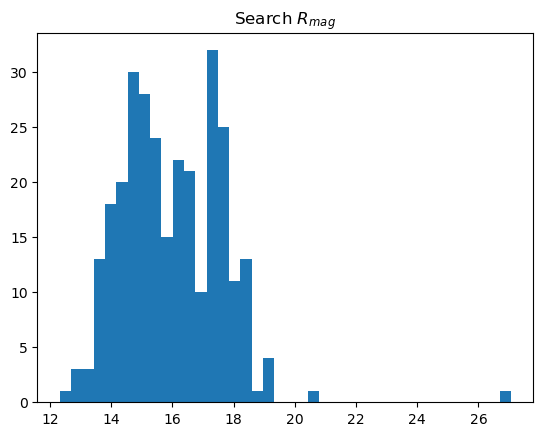

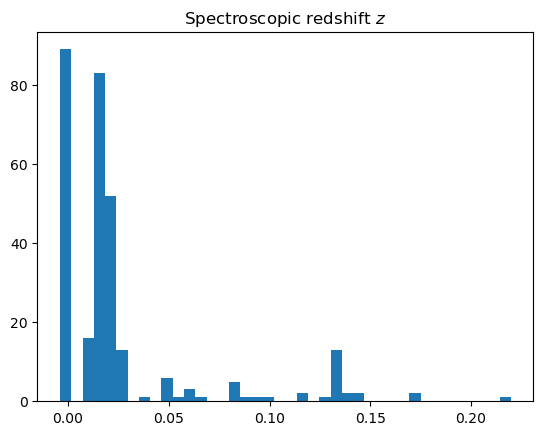

In [7]:
rmag = searchDf['modelMag_r']
plt.figure()
plt.hist(rmag, bins = 40)
plt.title('Search $R_{mag}$')
plt.show()

dfSorted = searchDf.sort_values(by=['objID'])
plt.figure()
plt.hist(dfSorted['z'].to_list(), bins = 40)
plt.title('Spectroscopic redshift $z$')
plt.show()

redshifts = searchDf['z']


In [8]:
pcc_crossmatchQuery = '''CREATE TABLE #upload ( up_id int, up_files varchar(32), up_name varchar(32), up_labels varchar(32), up_reds varchar(32), up_ra float, up_dec float ) 
INSERT INTO #upload values ( 1, 'sdss_ra=49.5885_dec=41.6896.png', 'PCC-2087', '0', '2.39', 49.5885, 41.6896),( 2, 'sdss_ra=49.4776_dec=41.384.png', 'PCC-1378', '0', '6.325', 49.4776, 41.384),( 3, 'sdss_ra=50.004_dec=41.341.png', 'PCC-5423', '0', '5.62', 50.004, 41.341),( 4, 'sdss_ra=49.4142_dec=41.3882.png', 'PCC-0989', '0', '1.6325', 49.4142, 41.3882),( 5, 'sdss_ra=50.0018_dec=41.6806.png', 'PCC-5408', '0', '1.8725', 50.0018, 41.6806),( 6, 'sdss_ra=49.6743_dec=41.3287.png', 'PCC-2818', '0', '0.04', 49.6743, 41.3287),( 7, 'sdss_ra=49.4266_dec=41.3159.png', 'PCC-1064', '0', '1.8225', 49.4266, 41.3159),( 8, 'sdss_ra=49.3303_dec=41.5381.png', 'PCC-0494', '0', '2.5825', 49.3303, 41.5381),( 9, 'sdss_ra=49.8286_dec=41.2883.png', 'PCC-4039', '0', '0.1675', 49.8286, 41.2883),( 10, 'sdss_ra=49.3925_dec=41.5647.png', 'PCC-0870', '0', '1.265', 49.3925, 41.5647),( 11, 'sdss_ra=49.4784_dec=41.2846.png', 'PCC-1388', '0', '3.62', 49.4784, 41.2846),( 12, 'sdss_ra=49.5392_dec=41.4577.png', 'PCC-1782', '0', '2.515', 49.5392, 41.4577),( 13, 'sdss_ra=49.7004_dec=41.5288.png', 'PCC-3025', '0', '1.695', 49.7004, 41.5288),( 14, 'sdss_ra=49.7521_dec=41.666.png', 'PCC-3450', '0', '1.74', 49.7521, 41.666),( 15, 'sdss_ra=49.7463_dec=41.6377.png', 'PCC-3408', '0', '5.7625', 49.7463, 41.6377),( 16, 'sdss_ra=49.7314_dec=41.5563.png', 'PCC-3286', '0', '17.815', 49.7314, 41.5563),( 17, 'sdss_ra=49.5063_dec=41.5123.png', 'PCC-1565', '0', '6.8275', 49.5063, 41.5123),( 18, 'sdss_ra=49.5319_dec=41.5225.png', 'PCC-1742', '0', '2.4475', 49.5319, 41.5225),( 19, 'sdss_ra=49.5132_dec=41.3783.png', 'PCC-1617', '0', '2.0275', 49.5132, 41.3783),( 20, 'sdss_ra=49.4477_dec=41.575.png', 'PCC-1191', '0', '1.6075', 49.4477, 41.575),( 21, 'sdss_ra=49.2565_dec=41.4396.png', 'PCC-0057', '0', '3.51', 49.2565, 41.4396),( 22, 'sdss_ra=49.3508_dec=41.3929.png', 'PCC-0626', '0', '19.445', 49.3508, 41.3929),( 23, 'sdss_ra=49.5144_dec=41.6052.png', 'PCC-1623', '0', '17.38', 49.5144, 41.6052),( 24, 'sdss_ra=49.3878_dec=41.5814.png', 'PCC-0826', '0', '0.705', 49.3878, 41.5814),( 25, 'sdss_ra=49.7118_dec=41.7236.png', 'PCC-3109', '0', '1.48', 49.7118, 41.7236),( 26, 'sdss_ra=49.7624_dec=41.308.png', 'PCC-3531', '0', '4.0975', 49.7624, 41.308),( 27, 'sdss_ra=49.8839_dec=41.7175.png', 'PCC-4515', '0', '6.82', 49.8839, 41.7175),( 28, 'sdss_ra=49.7006_dec=41.4398.png', 'PCC-3028', '0', '9.215', 49.7006, 41.4398),( 29, 'sdss_ra=49.6028_dec=41.5367.png', 'PCC-2195', '0', '8.365', 49.6028, 41.5367),( 30, 'sdss_ra=49.2466_dec=41.4451.png', 'PCC-0026', '0', '0.445', 49.2466, 41.4451),( 31, 'sdss_ra=49.6212_dec=41.7373.png', 'PCC-2365', '0', '2.2225', 49.6212, 41.7373),( 32, 'sdss_ra=49.407_dec=41.3729.png', 'PCC-0954', '0', '2.32', 49.407, 41.3729),( 33, 'sdss_ra=49.3329_dec=41.4999.png', 'PCC-0514', '0', '0.92', 49.3329, 41.4999),( 34, 'sdss_ra=49.2744_dec=41.5706.png', 'PCC-0160', '0', '1.22', 49.2744, 41.5706),( 35, 'sdss_ra=49.4898_dec=41.5315.png', 'PCC-1467', '0', '13.855', 49.4898, 41.5315),( 36, 'sdss_ra=49.4525_dec=41.5851.png', 'PCC-1222', '0', '1.9275', 49.4525, 41.5851),( 37, 'sdss_ra=49.3368_dec=41.4033.png', 'PCC-0538', '0', '13.4775', 49.3368, 41.4033),( 38, 'sdss_ra=49.5331_dec=41.4152.png', 'PCC-1749', '0', '2.0575', 49.5331, 41.4152),( 39, 'sdss_ra=49.5756_dec=41.4865.png', 'PCC-1992', '0', '2.2225', 49.5756, 41.4865),( 40, 'sdss_ra=50.0051_dec=41.6557.png', 'PCC-5428', '0', '1.8225', 50.0051, 41.6557),( 41, 'sdss_ra=49.7564_dec=41.2183.png', 'PCC-3477', '0', '6.9975', 49.7564, 41.2183),( 42, 'sdss_ra=49.6283_dec=41.2297.png', 'PCC-2441', '0', '13.07', 49.6283, 41.2297),( 43, 'sdss_ra=49.3541_dec=41.4703.png', 'PCC-0641', '0', '10.3425', 49.3541, 41.4703),( 44, 'sdss_ra=49.3081_dec=41.4699.png', 'PCC-0365', '0', '6.7025', 49.3081, 41.4699),( 45, 'sdss_ra=49.3881_dec=41.3949.png', 'PCC-0828', '0', '13.7625', 49.3881, 41.3949),( 46, 'sdss_ra=49.6684_dec=41.258.png', 'PCC-2760', '0', '4.1625', 49.6684, 41.258),( 47, 'sdss_ra=49.5907_dec=41.6753.png', 'PCC-2113', '0', '8.5275', 49.5907, 41.6753),( 48, 'sdss_ra=49.5877_dec=41.3917.png', 'PCC-2079', '0', '3.29', 49.5877, 41.3917),( 49, 'sdss_ra=49.4508_dec=41.5244.png', 'PCC-1208', '0', '0.745', 49.4508, 41.5244),( 50, 'sdss_ra=49.6184_dec=41.4546.png', 'PCC-2341', '0', '1.7125', 49.6184, 41.4546),( 51, 'sdss_ra=49.3497_dec=41.2962.png', 'PCC-0619', '0', '1.265', 49.3497, 41.2962),( 52, 'sdss_ra=49.9814_dec=41.4202.png', 'PCC-5240', '0', '1.585', 49.9814, 41.4202),( 53, 'sdss_ra=49.5539_dec=41.502.png', 'PCC-1867', '0', '10.2025', 49.5539, 41.502),( 54, 'sdss_ra=49.5094_dec=41.5135.png', 'PCC-1592', '0', '11.1625', 49.5094, 41.5135),( 55, 'sdss_ra=49.6309_dec=41.2656.png', 'PCC-2462', '0', '7.75', 49.6309, 41.2656),( 56, 'sdss_ra=49.4709_dec=41.3465.png', 'PCC-1336', '0', '0.0125', 49.4709, 41.3465),( 57, 'sdss_ra=49.2475_dec=41.3259.png', 'PCC-0027', '0', '1.7425', 49.2475, 41.3259),( 58, 'sdss_ra=49.623_dec=41.7693.png', 'PCC-2383', '0', '2.5125', 49.623, 41.7693),( 59, 'sdss_ra=49.9366_dec=41.7691.png', 'PCC-4910', '0', '2.935', 49.9366, 41.7691),( 60, 'sdss_ra=49.5669_dec=41.3688.png', 'PCC-1940', '0', '1.5825', 49.5669, 41.3688),( 61, 'sdss_ra=49.4854_dec=41.4154.png', 'PCC-1433', '0', '3.59', 49.4854, 41.4154),( 62, 'sdss_ra=49.4978_dec=41.6188.png', 'PCC-1515', '0', '3.41', 49.4978, 41.6188),( 63, 'sdss_ra=49.8832_dec=41.3043.png', 'PCC-4508', '0', '9.5525', 49.8832, 41.3043),( 64, 'sdss_ra=49.9842_dec=41.2138.png', 'PCC-5265', '0', '0.8025', 49.9842, 41.2138),( 65, 'sdss_ra=49.4511_dec=41.3201.png', 'PCC-1212', '0', '0.665', 49.4511, 41.3201),( 66, 'sdss_ra=49.7175_dec=41.6788.png', 'PCC-3159', '0', '12.7875', 49.7175, 41.6788),( 67, 'sdss_ra=49.7208_dec=41.5487.png', 'PCC-3190', '0', '42.3225', 49.7208, 41.5487),( 68, 'sdss_ra=49.9435_dec=41.6033.png', 'PCC-4967', '0', '18.6625', 49.9435, 41.6033),( 69, 'sdss_ra=49.8546_dec=41.2312.png', 'PCC-4260', '0', '4.5675', 49.8546, 41.2312),( 70, 'sdss_ra=49.5411_dec=41.5389.png', 'PCC-1795', '0', '6.025', 49.5411, 41.5389),( 71, 'sdss_ra=49.5078_dec=41.4149.png', 'PCC-1578', '0', '0.3725', 49.5078, 41.4149),( 72, 'sdss_ra=49.4815_dec=41.434.png', 'PCC-1406', '0', '0.8525', 49.4815, 41.434),( 73, 'sdss_ra=49.5511_dec=41.4042.png', 'PCC-1849', '0', '0.89', 49.5511, 41.4042),( 74, 'sdss_ra=49.9437_dec=41.3786.png', 'PCC-4969', '0', '7.01', 49.9437, 41.3786),( 75, 'sdss_ra=49.5475_dec=41.5225.png', 'PCC-1827', '0', '10.325', 49.5475, 41.5225),( 76, 'sdss_ra=49.8615_dec=41.4943.png', 'PCC-4319', '0', '23.2275', 49.8615, 41.4943),( 77, 'sdss_ra=49.6876_dec=41.226.png', 'PCC-2928', '0', '4.625', 49.6876, 41.226),( 78, 'sdss_ra=49.2669_dec=41.5264.png', 'PCC-0110', '0', '2.055', 49.2669, 41.5264),( 79, 'sdss_ra=49.3766_dec=41.5364.png', 'PCC-0774', '0', '0.0975', 49.3766, 41.5364),( 80, 'sdss_ra=49.5082_dec=41.4069.png', 'PCC-1581', '0', '2.4', 49.5082, 41.4069),( 81, 'sdss_ra=49.9564_dec=41.3138.png', 'PCC-5087', '0', '31.96', 49.9564, 41.3138),( 82, 'sdss_ra=49.7705_dec=41.3615.png', 'PCC-3605', '0', '7.835', 49.7705, 41.3615),( 83, 'sdss_ra=49.3431_dec=41.5987.png', 'PCC-0571', '0', '1.5575', 49.3431, 41.5987),( 84, 'sdss_ra=49.5268_dec=41.3295.png', 'PCC-1707', '0', '6.0975', 49.5268, 41.3295),( 85, 'sdss_ra=49.6744_dec=41.3395.png', 'PCC-2819', '0', '1.1975', 49.6744, 41.3395),( 86, 'sdss_ra=49.9834_dec=41.4553.png', 'PCC-5257', '0', '5.9725', 49.9834, 41.4553),( 87, 'sdss_ra=49.5811_dec=41.3339.png', 'PCC-2031', '0', '0.6825', 49.5811, 41.3339),( 88, 'sdss_ra=49.8625_dec=41.6234.png', 'PCC-4328', '0', '4.6825', 49.8625, 41.6234),( 89, 'sdss_ra=49.7875_dec=41.5292.png', 'PCC-3700', '0', '11.1775', 49.7875, 41.5292),( 90, 'sdss_ra=49.9985_dec=41.3856.png', 'PCC-5387', '0', '3.3975', 49.9985, 41.3856),( 91, 'sdss_ra=49.6469_dec=41.4505.png', 'PCC-2605', '0', '3.2575', 49.6469, 41.4505),( 92, 'sdss_ra=49.242_dec=41.4454.png', 'PCC-0011', '0', '0.24', 49.242, 41.4454),( 93, 'sdss_ra=49.4487_dec=41.3384.png', 'PCC-1198', '0', '1.0375', 49.4487, 41.3384),( 94, 'sdss_ra=49.9154_dec=41.2302.png', 'PCC-4755', '0', '3.9775', 49.9154, 41.2302),( 95, 'sdss_ra=49.5705_dec=41.4591.png', 'PCC-1967', '0', '4.16', 49.5705, 41.4591),( 96, 'sdss_ra=49.3855_dec=41.3037.png', 'PCC-0817', '0', '10.1125', 49.3855, 41.3037),( 97, 'sdss_ra=49.3893_dec=41.5721.png', 'PCC-0837', '0', '0.4225', 49.3893, 41.5721),( 98, 'sdss_ra=49.6164_dec=41.4551.png', 'PCC-2329', '0', '1.3825', 49.6164, 41.4551),( 99, 'sdss_ra=49.36_dec=41.3234.png', 'PCC-0675', '0', '0.555', 49.36, 41.3234),( 100, 'sdss_ra=49.985_dec=41.3319.png', 'PCC-5271', '0', '4.315', 49.985, 41.3319),( 101, 'sdss_ra=49.6116_dec=41.197.png', 'PCC-2283', '0', '1.5825', 49.6116, 41.197),( 102, 'sdss_ra=49.3594_dec=41.3355.png', 'PCC-0670', '0', '0.485', 49.3594, 41.3355),( 103, 'sdss_ra=49.5006_dec=41.3793.png', 'PCC-1530', '0', '0.575', 49.5006, 41.3793),( 104, 'sdss_ra=49.6822_dec=41.2678.png', 'PCC-2878', '0', '2.2375', 49.6822, 41.2678),( 105, 'sdss_ra=50.0028_dec=41.3384.png', 'PCC-5417', '0', '3.2525', 50.0028, 41.3384),( 106, 'sdss_ra=49.3464_dec=41.4658.png', 'PCC-0592', '0', '7.6125', 49.3464, 41.4658),( 107, 'sdss_ra=49.5247_dec=41.4305.png', 'PCC-1693', '0', '0.4275', 49.5247, 41.4305),( 108, 'sdss_ra=49.7345_dec=41.6346.png', 'PCC-3313', '0', '4.3675', 49.7345, 41.6346),( 109, 'sdss_ra=49.5236_dec=41.5182.png', 'PCC-1689', '0', '1.99', 49.5236, 41.5182),( 110, 'sdss_ra=49.4158_dec=41.3219.png', 'PCC-0997', '0', '3.605', 49.4158, 41.3219),( 111, 'sdss_ra=49.2411_dec=41.4991.png', 'PCC-0008', '0', '4.1925', 49.2411, 41.4991),( 112, 'sdss_ra=49.2758_dec=41.5415.png', 'PCC-0168', '0', '5.9025', 49.2758, 41.5415),( 113, 'sdss_ra=49.5591_dec=41.5027.png', 'PCC-1896', '0', '12.3575', 49.5591, 41.5027),( 114, 'sdss_ra=49.6769_dec=41.3202.png', 'PCC-2835', '0', '5.01', 49.6769, 41.3202),( 115, 'sdss_ra=49.8577_dec=41.3264.png', 'PCC-4286', '0', '3.9675', 49.8577, 41.3264),( 116, 'sdss_ra=49.2516_dec=41.3224.png', 'PCC-0040', '1', '4.3075', 49.2516, 41.3224),( 117, 'sdss_ra=49.2835_dec=41.3141.png', 'PCC-0219', '1', '3.31', 49.2835, 41.3141),( 118, 'sdss_ra=49.2874_dec=41.4252.png', 'PCC-0246', '1', '3.59', 49.2874, 41.4252),( 119, 'sdss_ra=49.3008_dec=41.3811.png', 'PCC-0314', '1', '11.765', 49.3008, 41.3811),( 120, 'sdss_ra=49.3048_dec=41.3333.png', 'PCC-0349', '1', '12.4125', 49.3048, 41.3333),( 121, 'sdss_ra=49.3063_dec=41.2975.png', 'PCC-0358', '1', '3.5275', 49.3063, 41.2975),( 122, 'sdss_ra=49.3067_dec=41.4355.png', 'PCC-0360', '1', '0.7175', 49.3067, 41.4355),( 123, 'sdss_ra=49.3237_dec=41.4215.png', 'PCC-0462', '1', '7.3625', 49.3237, 41.4215),( 124, 'sdss_ra=49.3256_dec=41.4929.png', 'PCC-0469', '1', '1.3375', 49.3256, 41.4929),( 125, 'sdss_ra=49.3476_dec=41.47.png', 'PCC-0602', '1', '13.6375', 49.3476, 41.47),( 126, 'sdss_ra=49.3663_dec=41.3535.png', 'PCC-0708', '1', '9.7675', 49.3663, 41.3535),( 127, 'sdss_ra=49.387_dec=41.297.png', 'PCC-0823', '1', '1.22', 49.387, 41.297),( 128, 'sdss_ra=49.4082_dec=41.3954.png', 'PCC-0958', '1', '10.75', 49.4082, 41.3954),( 129, 'sdss_ra=49.4134_dec=41.5176.png', 'PCC-0985', '1', '1.3875', 49.4134, 41.5176),( 130, 'sdss_ra=49.4149_dec=41.5612.png', 'PCC-0993', '1', '1.1775', 49.4149, 41.5612),( 131, 'sdss_ra=49.4273_dec=41.3231.png', 'PCC-1067', '1', '12.985', 49.4273, 41.3231),( 132, 'sdss_ra=49.4284_dec=41.5999.png', 'PCC-1078', '1', '8.705', 49.4284, 41.5999),( 133, 'sdss_ra=49.432_dec=41.3634.png', 'PCC-1101', '1', '8.7475', 49.432, 41.3634),( 134, 'sdss_ra=49.4519_dec=41.4084.png', 'PCC-1220', '1', '2.6575', 49.4519, 41.4084),( 135, 'sdss_ra=49.4615_dec=41.522.png', 'PCC-1282', '1', '0.8025', 49.4615, 41.522),( 136, 'sdss_ra=49.5028_dec=41.2991.png', 'PCC-1543', '1', '4.92', 49.5028, 41.2991),( 137, 'sdss_ra=49.5078_dec=41.5578.png', 'PCC-1577', '1', '1.0875', 49.5078, 41.5578),( 138, 'sdss_ra=49.5126_dec=41.5128.png', 'PCC-1613', '1', '8.615', 49.5126, 41.5128),( 139, 'sdss_ra=49.5154_dec=41.3231.png', 'PCC-1628', '1', '9.28', 49.5154, 41.3231),( 140, 'sdss_ra=49.5184_dec=41.3698.png', 'PCC-1655', '1', '5.9375', 49.5184, 41.3698),( 141, 'sdss_ra=49.5231_dec=41.4355.png', 'PCC-1684', '1', '3.385', 49.5231, 41.4355),( 142, 'sdss_ra=49.5244_dec=41.5814.png', 'PCC-1691', '1', '6.1025', 49.5244, 41.5814),( 143, 'sdss_ra=49.5308_dec=41.5539.png', 'PCC-1736', '1', '3.3825', 49.5308, 41.5539),( 144, 'sdss_ra=49.5486_dec=41.6169.png', 'PCC-1833', '1', '7.3675', 49.5486, 41.6169),( 145, 'sdss_ra=49.5502_dec=41.4233.png', 'PCC-1842', '1', '15.6625', 49.5502, 41.4233),( 146, 'sdss_ra=49.557_dec=41.4616.png', 'PCC-1884', '1', '2.215', 49.557, 41.4616),( 147, 'sdss_ra=49.5667_dec=41.2776.png', 'PCC-1937', '1', '9.0875', 49.5667, 41.2776),( 148, 'sdss_ra=49.568_dec=41.5799.png', 'PCC-1947', '1', '1.21', 49.568, 41.5799),( 149, 'sdss_ra=49.5741_dec=41.5031.png', 'PCC-1984', '1', '13.1275', 49.5741, 41.5031),( 150, 'sdss_ra=49.5791_dec=41.6937.png', 'PCC-2021', '1', '2.435', 49.5791, 41.6937),( 151, 'sdss_ra=49.582_dec=41.2943.png', 'PCC-2039', '1', '0.8525', 49.582, 41.2943),( 152, 'sdss_ra=49.5958_dec=41.2689.png', 'PCC-2146', '1', '6.9075', 49.5958, 41.2689),( 153, 'sdss_ra=49.5992_dec=41.6442.png', 'PCC-2172', '1', '29.7875', 49.5992, 41.6442),( 154, 'sdss_ra=49.6048_dec=41.5212.png', 'PCC-2214', '1', '1.2525', 49.6048, 41.5212),( 155, 'sdss_ra=49.6078_dec=41.5452.png', 'PCC-2241', '1', '5.425', 49.6078, 41.5452),( 156, 'sdss_ra=49.6152_dec=41.3213.png', 'PCC-2325', '1', '5.2975', 49.6152, 41.3213),( 157, 'sdss_ra=49.6169_dec=41.7091.png', 'PCC-2332', '1', '20.26', 49.6169, 41.7091),( 158, 'sdss_ra=49.6181_dec=41.286.png', 'PCC-2339', '1', '2.9925', 49.6181, 41.286),( 159, 'sdss_ra=49.6241_dec=41.3027.png', 'PCC-2393', '1', '8.96', 49.6241, 41.3027),( 160, 'sdss_ra=49.6382_dec=41.2977.png', 'PCC-2531', '1', '0.6525', 49.6382, 41.2977),( 161, 'sdss_ra=49.6396_dec=41.7522.png', 'PCC-2546', '1', '9.555', 49.6396, 41.7522),( 162, 'sdss_ra=49.6431_dec=41.4925.png', 'PCC-2571', '1', '3.9975', 49.6431, 41.4925),( 163, 'sdss_ra=49.6673_dec=41.4173.png', 'PCC-2754', '1', '2.19', 49.6673, 41.4173),( 164, 'sdss_ra=49.6693_dec=41.2867.png', 'PCC-2772', '1', '2.3975', 49.6693, 41.2867),( 165, 'sdss_ra=49.6694_dec=41.6242.png', 'PCC-2774', '1', '23.785', 49.6694, 41.6242),( 166, 'sdss_ra=49.6869_dec=41.6338.png', 'PCC-2918', '1', '2.355', 49.6869, 41.6338),( 167, 'sdss_ra=49.6925_dec=41.4049.png', 'PCC-2959', '1', '1.8125', 49.6925, 41.4049),( 168, 'sdss_ra=49.6929_dec=41.6028.png', 'PCC-2961', '1', '4.5675', 49.6929, 41.6028),( 169, 'sdss_ra=49.6991_dec=41.748.png', 'PCC-3010', '1', '6.1725', 49.6991, 41.748),( 170, 'sdss_ra=49.7077_dec=41.5067.png', 'PCC-3076', '1', '12.3', 49.7077, 41.5067),( 171, 'sdss_ra=49.712_dec=41.6398.png', 'PCC-3116', '1', '9.2625', 49.712, 41.6398),( 172, 'sdss_ra=49.7177_dec=41.2676.png', 'PCC-3164', '1', '8.89', 49.7177, 41.2676),( 173, 'sdss_ra=49.7227_dec=41.3095.png', 'PCC-3205', '1', '16.1025', 49.7227, 41.3095),( 174, 'sdss_ra=49.727_dec=41.2225.png', 'PCC-3244', '1', '5.9825', 49.727, 41.2225),( 175, 'sdss_ra=49.7333_dec=41.5787.png', 'PCC-3303', '1', '4.17', 49.7333, 41.5787),( 176, 'sdss_ra=49.7334_dec=41.6862.png', 'PCC-3305', '1', '6.01', 49.7334, 41.6862),( 177, 'sdss_ra=49.735_dec=41.2599.png', 'PCC-3316', '1', '2.2425', 49.735, 41.2599),( 178, 'sdss_ra=49.7397_dec=41.359.png', 'PCC-3361', '1', '6.2725', 49.7397, 41.359),( 179, 'sdss_ra=49.7405_dec=41.4161.png', 'PCC-3366', '1', '33.7925', 49.7405, 41.4161),( 180, 'sdss_ra=49.7415_dec=41.6351.png', 'PCC-3379', '1', '8.6625', 49.7415, 41.6351),( 181, 'sdss_ra=49.7454_dec=41.3209.png', 'PCC-3401', '1', '8.215', 49.7454, 41.3209),( 182, 'sdss_ra=49.7484_dec=41.4446.png', 'PCC-3418', '1', '3.915', 49.7484, 41.4446),( 183, 'sdss_ra=49.7516_dec=41.484.png', 'PCC-3444', '1', '10.1325', 49.7516, 41.484),( 184, 'sdss_ra=49.7624_dec=41.5043.png', 'PCC-3529', '1', '7.785', 49.7624, 41.5043),( 185, 'sdss_ra=49.7817_dec=41.2523.png', 'PCC-3661', '1', '5.35', 49.7817, 41.2523),( 186, 'sdss_ra=49.7852_dec=41.5811.png', 'PCC-3687', '1', '11.5075', 49.7852, 41.5811),( 187, 'sdss_ra=49.7895_dec=41.7047.png', 'PCC-3723', '1', '1.0425', 49.7895, 41.7047),( 188, 'sdss_ra=49.7926_dec=41.6781.png', 'PCC-3742', '1', '8.12', 49.7926, 41.6781),( 189, 'sdss_ra=49.7935_dec=41.4936.png', 'PCC-3749', '1', '15.975', 49.7935, 41.4936),( 190, 'sdss_ra=49.7995_dec=41.7588.png', 'PCC-3799', '1', '1.625', 49.7995, 41.7588),( 191, 'sdss_ra=49.8124_dec=41.6778.png', 'PCC-3919', '1', '1.6575', 49.8124, 41.6778),( 192, 'sdss_ra=49.8126_dec=41.2313.png', 'PCC-3921', '1', '7.695', 49.8126, 41.2313),( 193, 'sdss_ra=49.8178_dec=41.7537.png', 'PCC-3963', '1', '4.4325', 49.8178, 41.7537),( 194, 'sdss_ra=49.8495_dec=41.6924.png', 'PCC-4208', '1', '10.34', 49.8495, 41.6924),( 195, 'sdss_ra=49.8501_dec=41.5332.png', 'PCC-4216', '1', '31.8775', 49.8501, 41.5332),( 196, 'sdss_ra=49.8585_dec=41.2621.png', 'PCC-4297', '1', '2.2225', 49.8585, 41.2621),( 197, 'sdss_ra=49.8627_dec=41.6082.png', 'PCC-4330', '1', '7.4875', 49.8627, 41.6082),( 198, 'sdss_ra=49.8715_dec=41.7361.png', 'PCC-4402', '1', '2.66', 49.8715, 41.7361),( 199, 'sdss_ra=49.8823_dec=41.5225.png', 'PCC-4499', '1', '20.3575', 49.8823, 41.5225),( 200, 'sdss_ra=49.8902_dec=41.5536.png', 'PCC-4551', '1', '9.5975', 49.8902, 41.5536),( 201, 'sdss_ra=49.8969_dec=41.6179.png', 'PCC-4608', '1', '6.21', 49.8969, 41.6179),( 202, 'sdss_ra=49.9053_dec=41.486.png', 'PCC-4666', '1', '11.84', 49.9053, 41.486),( 203, 'sdss_ra=49.9145_dec=41.2779.png', 'PCC-4743', '1', '15.625', 49.9145, 41.2779),( 204, 'sdss_ra=49.9151_dec=41.5179.png', 'PCC-4750', '1', '17.335', 49.9151, 41.5179),( 205, 'sdss_ra=49.9175_dec=41.3292.png', 'PCC-4771', '1', '4.87', 49.9175, 41.3292),( 206, 'sdss_ra=49.9235_dec=41.4881.png', 'PCC-4811', '1', '18.5525', 49.9235, 41.4881),( 207, 'sdss_ra=49.9248_dec=41.4995.png', 'PCC-4816', '1', '30.525', 49.9248, 41.4995),( 208, 'sdss_ra=49.9317_dec=41.7131.png', 'PCC-4867', '1', '9.17', 49.9317, 41.7131),( 209, 'sdss_ra=49.9326_dec=41.457.png', 'PCC-4876', '1', '15.7675', 49.9326, 41.457),( 210, 'sdss_ra=49.936_dec=41.4465.png', 'PCC-4900', '1', '17.76', 49.936, 41.4465),( 211, 'sdss_ra=49.9449_dec=41.5293.png', 'PCC-4979', '1', '14.675', 49.9449, 41.5293),( 212, 'sdss_ra=49.9453_dec=41.3786.png', 'PCC-4981', '1', '9.1025', 49.9453, 41.3786),( 213, 'sdss_ra=49.9523_dec=41.5579.png', 'PCC-5047', '1', '28.535', 49.9523, 41.5579),( 214, 'sdss_ra=49.9538_dec=41.5834.png', 'PCC-5063', '1', '16.9225', 49.9538, 41.5834),( 215, 'sdss_ra=49.9574_dec=41.3299.png', 'PCC-5095', '1', '17.1275', 49.9574, 41.3299),( 216, 'sdss_ra=49.9575_dec=41.6693.png', 'PCC-5096', '1', '1.0675', 49.9575, 41.6693),( 217, 'sdss_ra=49.9635_dec=41.5354.png', 'PCC-5136', '1', '25.4425', 49.9635, 41.5354),( 218, 'sdss_ra=49.9636_dec=41.3097.png', 'PCC-5137', '1', '7.905', 49.9636, 41.3097),( 219, 'sdss_ra=49.9656_dec=41.3923.png', 'PCC-5147', '1', '2.3325', 49.9656, 41.3923),( 220, 'sdss_ra=49.967_dec=41.2598.png', 'PCC-5156', '1', '2.78', 49.967, 41.2598),( 221, 'sdss_ra=49.9672_dec=41.648.png', 'PCC-5157', '1', '2.3475', 49.9672, 41.648),( 222, 'sdss_ra=49.9686_dec=41.5498.png', 'PCC-5163', '1', '9.2', 49.9686, 41.5498),( 223, 'sdss_ra=49.9705_dec=41.6088.png', 'PCC-5169', '1', '6.5925', 49.9705, 41.6088),( 224, 'sdss_ra=49.9756_dec=41.3089.png', 'PCC-5196', '1', '11.9175', 49.9756, 41.3089),( 225, 'sdss_ra=49.9932_dec=41.5479.png', 'PCC-5339', '1', '28.4075', 49.9932, 41.5479),( 226, 'sdss_ra=49.9947_dec=41.75.png', 'PCC-5358', '1', '49.0425', 49.9947, 41.75),( 227, 'sdss_ra=49.9967_dec=41.3092.png', 'PCC-5374', '1', '17.355', 49.9967, 41.3092),( 228, 'sdss_ra=49.8825_dec=41.7447.png', 'PCC-4502', '1', '4.63', 49.8825, 41.7447),( 229, 'sdss_ra=49.9387_dec=41.2544.png', 'PCC-4932', '1', '5.585', 49.9387, 41.2544)
create table #x (up_id int,objID bigint)
INSERT INTO #x 
SELECT up_id, dbo.fGetNearestObjIdEq(up_ra,up_dec,0.03) as objId 
     FROM #upload WHERE dbo.fGetNearestObjIdEq(up_ra,up_dec,0.03) IS NOT NULL 
SELECT u.up_files as [files],u.up_name as [name],u.up_labels as [labels],u.up_reds as [reds], 
p.objID, 
dbo.fPhotoTypeN(p.type) as type,
p.ra, p.dec,
p.modelMag_r, 
p.modelMag_u - p.modelMag_g as u_g, 
p.modelMag_g - p.modelMag_z as g_z, 
p.modelMag_g - p.modelMag_r as g_r, 
p.modelMag_g - p.modelMag_i as g_i, 
p.modelMag_r - p.modelMag_i as r_i, 
p.modelMag_r - p.modelMag_z as r_z, 
p.petroRad_r,
p.flags, dbo.fPhotoFlagsN(p.flags) as flag_text
FROM #upload u
JOIN #x x ON x.up_id = u.up_id
JOIN PhotoObj p ON p.objID = x.objID 
ORDER BY x.up_id
'''
pcc_crossDf = CasJobs.executeQuery(pcc_crossmatchQuery, "dr16")
pcc_crossDf

,files,name,labels,reds,objID,type,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r,flags,flag_text
0,sdss_ra=49.5885_dec=41.6896.png,PCC-2087,0,2.39,1237661059574204597,GALAXY,49.588519,41.689635,19.13894,1.366329,1.683722,0.928186,1.477312,0.549126,0.755535,4.349349,105624251793424,DEBLEND_NOPEAK DEBLENDED_AT_EDGE STATIONARY MO...
1,sdss_ra=50.004_dec=41.341.png,PCC-5423,0,5.62,1237661055281857482,GALAXY,50.003964,41.340957,17.69603,2.224802,2.140968,1.194695,1.712109,0.517414,0.946274,4.118130,35259802583056,DEBLENDED_AT_EDGE STATIONARY DEBLENDED_AS_MOVI...
2,sdss_ra=50.0018_dec=41.6806.png,PCC-5408,0,1.8725,1237661055818662907,STAR,50.001808,41.680561,18.41516,1.325253,0.945162,0.589443,0.812901,0.223457,0.355719,0.952807,35255507484688,DEBLENDED_AT_EDGE STATIONARY MOVED BINNED1 CHILD
3,sdss_ra=49.6743_dec=41.3287.png,PCC-2818,0,0.04,1237661122387969064,GALAXY,49.674327,41.328677,19.03402,3.501022,2.398468,1.429430,2.012350,0.582920,0.969038,2.761945,68987912448,STATIONARY BINNED1 NOPETRO
4,sdss_ra=49.4266_dec=41.3159.png,PCC-1064,0,1.8225,1237661083199145950,GALAXY,49.426634,41.315896,19.41731,2.216972,2.613037,1.564829,2.160494,0.595665,1.048208,2.570463,68988047360,STATIONARY BINNED1 INTERP COSMIC_RAY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,sdss_ra=49.9705_dec=41.6088.png,PCC-5169,1,6.5925,1237661059574334013,GALAXY,49.970506,41.608786,15.59959,1.906456,1.674442,0.899385,1.351961,0.452576,0.775057,12.831900,193583034536024,PSF_FLUX_INTERP DEBLENDED_AT_EDGE INTERP_CENTE...
203,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,1237670960021504409,GALAXY,49.994725,41.750034,17.53399,6.157221,1.576391,0.871559,1.323565,0.452005,0.704832,8.789475,105622104310032,DEBLEND_NOPEAK DEBLENDED_AT_EDGE STATIONARY BI...
204,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.355,1237661055281857031,STAR,49.996200,41.309363,22.91631,1.041622,1.991064,1.159723,1.114315,-0.045408,0.831341,1.055185,457465859019024,TOO_FEW_GOOD_DETECTIONS PSF_FLUX_INTERP DEBLEN...
205,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.63,1237670458048446875,GALAXY,49.882513,41.744532,19.29449,3.955753,-0.534899,0.685694,1.386385,0.700691,-1.220592,7.691484,527834569642256,TOO_FEW_GOOD_DETECTIONS PSF_FLUX_INTERP DEBLEN...


In [9]:
template = lambda starID : f'https://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id={starID}'
# jpg_temp = lambda starID : 'https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/'\
#           f'getjpeg?TaskName=Skyserver.Explore.Image&id={starID}&scale=0.1&width=200&height=200'
search = set(searchDf['objID'].to_list())
pccObjs = set(pcc_crossDf['objID'].to_list())

hits = set.intersection(search, pccObjs)

# for x in hits:
#     print(template(x))

In [10]:
len(list(hits))

16

In [11]:
#get an image cutout

SkyServer_DataRelease = 'DR16'
img = SkyServer.getJpegImgCutout(ra=197.614455642896, dec=18.438168853724, width=2, height=2, scale=0.4, 
                                 dataRelease=SkyServer_DataRelease,opt="OG",
                                 query="SELECT TOP 100 p.objID, p.ra, p.dec, p.r FROM fGetObjFromRectEq(197.6,18.4,197.7,18.5) n, PhotoPrimary p WHERE n.objID=p.objID")

# plt.imshow(img)
# img_array = SkyServer.getJpegImgCutout(ra=197.614455642896, dec=18.438168853724, width=200, height=200, scale=0.1, 
#                                  dataRelease=SkyServer_DataRelease)
# plt.imshow(img_array) # imshow leaves axes
# from PIL import Image

## this method avoids the axes
# img0 = Image.fromarray(img_array, 'RGB')
# img0.save('my.png')
# img0

In [12]:
# searchDf2 = searchDf.loc[(searchDf['z'] > 0.01 & searchDf['z'] < 0.033)]
searchDf_specMembers = searchDf.loc[(searchDf['z'] > 0.01) & (searchDf['z'] < 0.033)]
# 0.01 < spec-z < 0.033
searchDf_specNonMembers = searchDf.loc[(searchDf['z'] < 0.01) | (searchDf['z'] > 0.033)]
pcc_nonMembers = pcc_crossDf.loc[(pcc_crossDf['labels'] == '0')]
pcc_Members = pcc_crossDf.loc[(pcc_crossDf['labels'] == '1')]
# searchDf_specNonMembers.shape

In [13]:
searchDf_specNonMembers.shape

(134, 22)

In [14]:
colorcode = []
for x in pcc_crossDf['labels'].to_list():
    if x == '0':
        colorcode.append('C0')
    else:
        colorcode.append('C1')



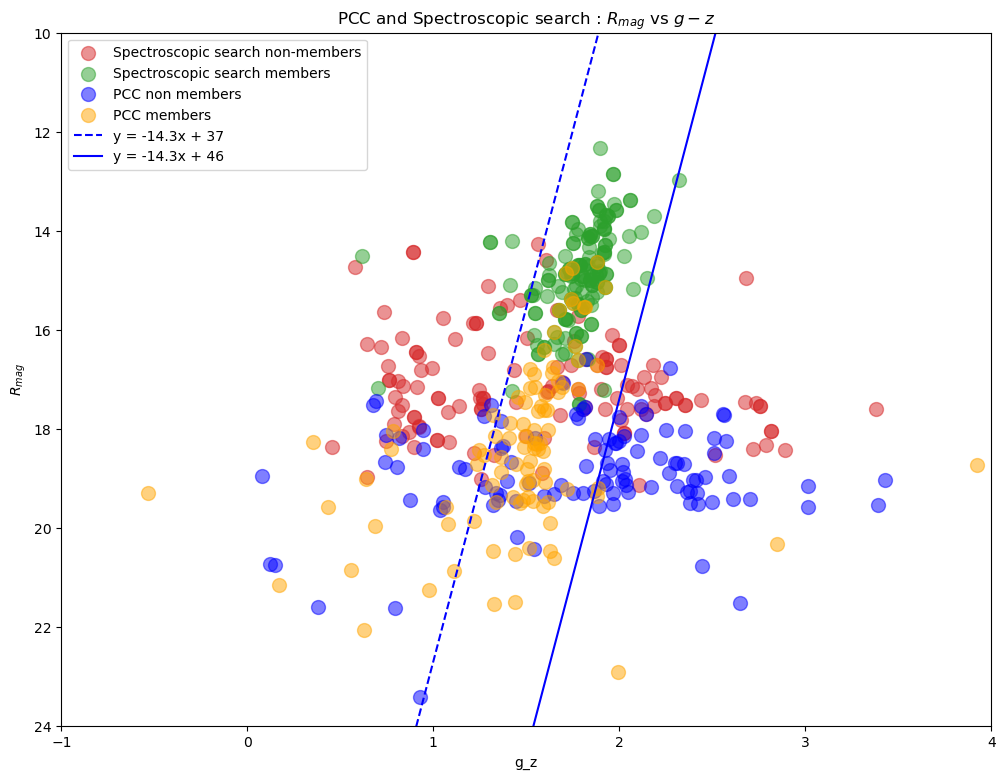

In [15]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?
xx = np.linspace(0, 4) 
## TODO -- Get classes on this plot

plt.figure(figsize = (12, 9))
# plt.scatter(searchDf_specNonMembers['g_z'], searchDf_specNonMembers['modelMag_r'],  s = 100, c = '#888888', alpha = 1, label = 'Spectroscopic search non-members')
plt.scatter(searchDf_specNonMembers['g_z'], searchDf_specNonMembers['modelMag_r'],  s = 100, c = 'C3', alpha = .5, label = 'Spectroscopic search non-members')
plt.scatter(searchDf_specMembers['g_z'], searchDf_specMembers['modelMag_r'],  s = 100, c = 'C2', alpha = .5, label = 'Spectroscopic search members')
# plt.scatter(pcc_crossDf['g_z'], pcc_crossDf['modelMag_r'], s = 100, c = colorcode, alpha = .5, label = 'PCC non members') # legend does not distinguish between blue nonmembers and orange members
plt.scatter(pcc_nonMembers['g_z'], pcc_nonMembers['modelMag_r'], s = 100, c = 'blue', alpha = .5, label = 'PCC non members')
plt.scatter(pcc_Members['g_z'], pcc_Members['modelMag_r'], s = 100, c = 'orange', alpha = .5, label = 'PCC members') 
# plt.scatter(pcc_Members['g_z'], pcc_Members['modelMag_r'], s = 100, c = '#AA4499', alpha = .5, label = 'PCC members') #888888

plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')

plt.ylabel('$R_{mag}$')
plt.xlabel('g_z')
plt.title('PCC and Spectroscopic search : $R_{mag}$ vs $g-z$')
plt.ylim([24, 10])
plt.xlim([-1, 4])
plt.legend()
plt.show()